<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# 1. SINDy (sparse identification of the non-linear dynamics) in Groud Truth Coordinates z

1.1 Simulation


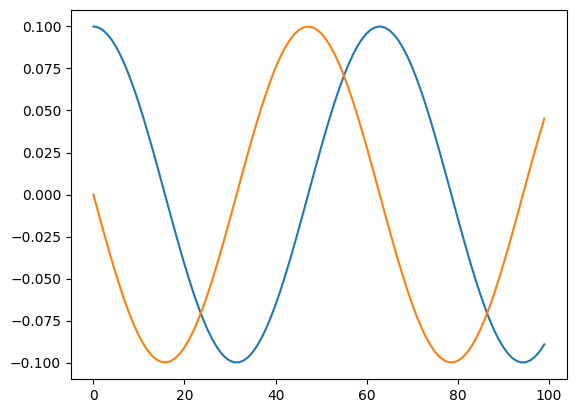

In [46]:
import numpy as np
from scipy.integrate import odeint

# Define the pendulum_rhs function
def pendulum_rhs(z, dzdt, coefficients, terms):
    return np.dot(terms(z), coefficients)

# Define the pendulum_ode_step function
def pendulum_ode_step(y, t, coefficients, terms):
    D = len(y) // 2
    z_values = y[:D]
    dzdt_values = y[D:]

    # Evaluate rhs using the current terms
    rhs = pendulum_rhs(z_values, dzdt_values, coefficients, terms)

    # Check if rhs is 1-dimensional or 2-dimensional
    if np.ndim(rhs) == 1:
        dydt = np.concatenate([dzdt_values, rhs])
    else:
        dydt = np.concatenate([dzdt_values, rhs[1]])

    return dydt

# Function to simulate the pendulum using odeint
def simulate_pendulum(y0, coefficients, terms, T, dt):
    # Call odeint with the pendulum_ode_step function
    result = odeint(pendulum_ode_step, y0, np.arange(0, T, dt), args=(coefficients, terms))

    return result


D = 1
L = 1
z0 = np.array([0.1])
dz0 = np.array([0.0])
coefficients = np.array([[-1.0]])

# Define terms as a vector of functions (sine function in this case)
terms = lambda z: np.sin(z)

T = 10.0
dt = 0.1
y0 = np.concatenate([z0, dz0])

result = simulate_pendulum(y0, coefficients, terms, T, dt)
plt.plot(result)

In [79]:
def create_pendulum_data(z0_min, z0_max,
                         dz0_min, dz0_max,
                         coefficients, terms,
                         T, dt, N,
                         embedding=None, rejection=True):
    data = []

    for _ in range(N):
        while True:
            z0 = np.array([np.random.uniform(z0_min, z0_max)])
            dz0 = np.array([np.random.uniform(dz0_min, dz0_max)])

            if not rejection:
                break  # No rejection, proceed with the simulation

            angular_momentum = 0.5 * (dz0 ** 2) - np.cos(z0)
            print("angular_momentum", np.abs(angular_momentum))

            if np.abs(angular_momentum) <= 0.99:
                break  # Angular momentum condition satisfied, proceed with the simulation

        simulation_result = simulate_pendulum(np.concatenate([z0, dz0]), coefficients, terms, T, dt)
        second_derivative = pendulum_ode_step(simulation_result[-1], T, coefficients, terms)

        if embedding is not None:
            # Add code for artificial embedding (needed later)
            pass

        data.append((simulation_result[:, :D], simulation_result[:, D:], second_derivative[D:]))

    return data


In [82]:
# checking something:

z0_min = -np.pi
z0_max = np.pi
dz0_min = -2.1
dz0_max = 2.1
coefficients = np.array([[-1.0]])
terms = lambda z: np.sin(z)

T = 50.0
dt = 0.02
N = 1
embedding = None
rejection = True

training_data = create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max,
                                     coefficients, terms, T, dt, N, embedding, rejection)

print("training_data:")
print(training_data)

angular_momentum [2.32692404]
angular_momentum [0.76825535]
training_data:
[(array([[1.71136025],
       [1.68874499],
       [1.66573254],
       ...,
       [1.95214325],
       [1.9341564 ],
       [1.91579568]]), array([[-1.12085133],
       [-1.14068396],
       [-1.16057029],
       ...,
       [-0.8900388 ],
       [-0.9086678 ],
       [-0.92742594]]), array([-0.94107567]))]


# Everything below is not important

In [ ]:
import numpy as np

def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding=None, rejection=True):
    """
    Create a training set of N simulations for the pendulum.

    Parameters:
    - z0_min: array-like, shape (D,)
        Minimum values for the variables.
    - z0_max: array-like, shape (D,)
        Maximum values for the variables.
    - dz0_min: array-like, shape (D,)
        Minimum values for the derivatives.
    - dz0_max: array-like, shape (D,)
        Maximum values for the derivatives.
    - coefficients: array-like, shape (L, D)
        Coefficient matrix Ξ.
    - terms: array-like, shape (T, L)
        Library matrix Θ(z, z˙).
    - T: float
        Total simulation time.
    - dt: float
        Time step.
    - N: int
        Number of simulations to create.
    - embedding: str or None, optional
        Type of artificial embedding into Cartesian coordinates or a video.
    - rejection: bool, optional
        Whether to reject simulations with too much angular momentum.

    Returns:
    - data: list
        List containing tuples (time_points, simulation_result) for each simulation.
    """
    data = []

    for _ in range(N):
        # Generate random initial conditions within the specified range
        z0 = np.random.uniform(z0_min, z0_max)
        dz0 = np.random.uniform(dz0_min, dz0_max)

        # Check for angular momentum rejection condition
        if rejection:
            angular_momentum = 0.5 * (
              pendulum_rhs(z0, dz0, coefficients, terms)[0, 1])**2 - np.cos(z0)
            if np.abs(angular_momentum) > 0.99:
                continue  # Reject simulation and sample a new one

        # Simulate the pendulum
        time_points, simulation_result = simulate_pendulum(z0, dz0, coefficients, terms, T, dt)

        # Optionally, perform artificial embedding
        if embedding is not None:
            # Add code for artificial embedding (needed later)
            pass

        data.append((time_points, simulation_result))

    return data

# Example usage
# z0_min = np.array([0.0])
# z0_max = np.array([2*np.pi])
# dz0_min = np.array([-2.0])
# dz0_max = np.array([2.0])
# coefficients = np.random.rand(L, D)
# terms = np.random.rand(100, L)
# T = 10.0
# dt = 0.01
# N = 100
# embedding = None
# rejection = True

# training_data = create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding, rejection)



In [ ]:
# def pendulum_ode_step(y, t, coefficients, terms):
#     """
#     Define the right-hand side of the ODE for the simple pendulum.

#     Parameters:
#     - y: array-like, shape (2,)
#         Current values of z and dz/dt.
#     - t: float
#         Current time.
#     - coefficients: array-like, shape (L, D)
#         Coefficient matrix Ξ.
#     - terms: array-like, shape (T, L)
#         Library matrix Θ(z, z˙).

#     Returns:
#     - dydt: array-like, shape (2,)
#         Derivatives of z and dz/dt at the current time.
#     """
#     z, dzdt = y

#     # Compute the scalar product Θ(z, z˙) · Ξ at the current time
#     rhs = pendulum_rhs(np.array([z]), np.array([dzdt]), coefficients, terms)

#     # Extract the derivatives
#     dzdt_new = rhs[0, 1]

#     # Return the derivatives
#     dydt = [dzdt, dzdt_new]

#     return dydt

# ##########
# from scipy.integrate import odeint

# # Define other parameters
# z0 = 0.1
# dz0 = 0.0
# T = 10.0
# dt = 0.01
# coefficients = ...  #  coefficients
# terms = ...         #  library matrix

# # Initial conditions
# y0 = [z0, dz0]

# # Call odeint with pendulum_ode_step as the func parameter
# result = odeint(pendulum_ode_step, y0, np.arange(0, T, dt), args=(coefficients, terms))


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE system
def my_ode(y, t):
    dydt = -2 * y  # Example: simple exponential decay
    return dydt

# Initial condition
y0 = 1.0

# Time points
t = np.linspace(0, 5, 101)

# Solve the ODE using odeint
solution = odeint(my_ode, y0, t)

# Plot the solution
plt.plot(t, solution)
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('ODE Solution')
plt.show()
